# <center>MACHINE LEARNING <br> <br> L7b <br> Linear Regression and Regularisation</center>

In [1]:
%matplotlib notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d.axes3d import Axes3D

In [14]:
def constructDesignMatrix1D(x,deg):
    X = np.ones(x.shape)
    
    for i in range(deg):
        X = np.hstack((X,x**(i+1)))
    
    return X

def computeError(X,y,w):
    # computeCost : average sum of squares error. Expects
    #     X : NxD design matrix
    #     t : Nx1 target response variable
    #     theta : model parameters
    N = len(y)
    aux = np.dot(X,w) - y
    return np.sum( aux**2 , axis = 0 ) / 2


def gradientDescent_RidgeReg(X, y, w, alpha, reg, maxIts,tol):
    # gradientDescent expects 
    #     X : matrix of shape NxD
    #     y : vector of shape Nx1
    #     alpha : learning rate
    #     reg :  lambda, regularisation parameter
    #     maxIts : max number of iterations
    #     tol : absolute tolerance error

    w_vec = np.zeros([len(w),maxIts])
    error_vec = np.zeros([maxIts])
    N = len(y) # number of training examples
    iteracions = 1

    for it in range(maxIts):
        # error for current parameters theta : w^T * X - y
        error = np.dot(X, w) - y
        
        # gradient : X^T * error
        grad = np.dot(X.T, error)
        
        # update : w = w - alpha/N * grad - alpha * reg * w
        w = w - (alpha/N) * grad - alpha * reg * w
        
        # save current it params and error
        w_vec[:,it] = np.reshape(w,(len(w),))
        error_vec[it] = computeError(X, y, w)
        
        iteracions = iteracions+1
        # check convergence
        if it > 0 and abs( error_vec[it] - error_vec[it-1] ) < tol:
            
            return w_vec[:,:it+1], error_vec[:it+1],iteracions
        
    return w_vec, error_vec,iteracions



def plotModel1D(w,x):
    xL = np.min(x) - abs(np.max(x)-np.min(x))/2
    xR = np.max(x) + abs(np.max(x)-np.min(x))/2
    x_plot = np.reshape(np.linspace(xL,xR,50), (50,x.shape[1]))
    
    deg = len(w) - 1
    X_plot = np.ones(x_plot.shape)
    for i in range(deg):
        X_plot = np.hstack((X_plot,x_plot**(i+1)))
            
    plt.plot(x_plot,np.dot(X_plot,w),'-')
    

def plotError3D(X,y,w,ax,**kwargs):
    
    error = computeError(X,y,w)
    aux = error < 1e5
    error = error[aux]
    w = w[:,aux]
    
    # Plot w evolution
    if w.shape[1] < 3:
        ax.scatter3D(w[0,:],w[1,:],errors,s=20,c='r')
        if w.shape[1] > 1:
            vec = np.hstack((w[:,1],errors[1])) - np.hstack((w[:,0],errors[0]))
            ax.quiver3D(w[0,0], w[1,0], errors[0], vec[0] ,vec[1], vec[2], arrow_length_ratio=.0001)
    else:
        ax.scatter3D(w[0,:],w[1,:],error,s=5,c = range(len(error)))
    
    
    # Plot E(w) surface
    w0L = np.min(w[0,:]) - abs(np.max(w[0,:])-np.min(w[0,:]))/2
    w0R = np.max(w[0,:]) + abs(np.max(w[0,:])-np.min(w[0,:]))/2
    w1L = np.min(w[1,:]) - abs(np.max(w[1,:])-np.min(w[1,:]))/2
    w1R = np.max(w[1,:]) + abs(np.max(w[1,:])-np.min(w[1,:]))/2
    
    
    for keyWord, kw_value in kwargs.items():
        if keyWord == 'w0Lims':
            w0L = kw_value[0]
            w0R = kw_value[1]
        elif keyWord == 'w1Lims':
            w1L = kw_value[0]
            w1R = kw_value[1]
        else:
            raise NameError('Undefined input argument.')
    
    
    w0 = np.linspace(w0L, w0R, 50)
    w1 = np.linspace(w1L, w1R, 50)
    w0, w1 = np.meshgrid(w0, w1)

    errorMesh = computeError( X, y, np.array([w0.flatten(),w1.flatten()]) )
    errorMesh = np.reshape(errorMesh,w0.shape)

    ax.plot_surface(w0, w1, errorMesh, cmap=cm.coolwarm, linewidth=0, antialiased=False, alpha = 0.2)

## Exercise 1

Consider the following training set $\left\{ \left(x^{(i)}, y^{(i)}\right) \right\}_{i = 1}^5$ with feature variables $\left\{ x^{(1)} = 10, x^{(2)} = 10, x^{(3)} = 20, x^{(4)} = 35, x^{(5)} = 40\right\}$ and target variables $\left\{ y^{(1)} = 10, y^{(2)} = 20, y^{(3)} = 20, y^{(4)} = 25, y^{(5)} = 35 \right\}$.

a) *Closed-form solution*

i. Estimate the parameters of a Linear Regression model using the closed-form solution and the parameters when a Ridge regression is applied, using also the closed-form solution, with $\lambda = 1$.


ii. Compute the error in the training set for both models and plot the training set and both models in the same figure.

What differences are between the models? What is the effect of the regularisation?

In [13]:
x = np.array([[10,10,20,35,40]]).T # column vector, each entry is a sample
y = np.array([[10,20,20,25,30]]).T # column vector, each entry is the ground truth response of a sample
deg = 1 # degree of model to be fitted

# Construct design matrix [1,x,x^2,x^3,...,x^deg]
X_mat = constructDesignMatrix1D(x,deg)

# Closed-form solution w/o regularisation
w_cf = np.dot(np.linalg.inv(np.dot(X_mat.T, X_mat)), np.dot(X_mat.T, y))
print('w without regularisation = {}'.format(w_cf.T))

# Closed-form solution with regularisation, lambda = 1
lReg = 1
wReg_cf = np.dot(np.linalg.inv(np.dot(X_mat.T, X_mat) + (lReg)*np.eye(deg+1)), np.dot(X_mat.T, y))
print('w with regularisation = {}'.format(wReg_cf.T))

# Errors
print('Error without regularisation = {}'.format(computeError(X_mat,y,w_cf)))
print('Error with regularisation = {}'.format(computeError(X_mat,y,wReg_cf)))

# Plot both models
fig = plt.figure(figsize=(5,5))
plt.scatter(x,y)
plotModel1D(w_cf,x)
plotModel1D(wReg_cf,x)
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.grid('on')
plt.legend(['Without reg', 'With reg'])
plt.show()

w without regularisation = [[10.38461538  0.46153846]]
w with regularisation = [[5.5388078 0.6240622]]
Error without regularisation = [26.92307692]
Error with regularisation = [40.29236288]


<IPython.core.display.Javascript object>

b) Compute a Gradient Descent update for a **Linear regression model**. Consider initial parameters $w_0 = 0, w_1 = 0$ and learning rate $\alpha = 0.001$.

i. Write the parametric form of a linear regression model $g(\mathbf{x},\mathbf{w})$ and the error function that is minimised when fitting a linear model to the **given data**.
   
ii. Find the expression of the gradient descent update of the parameters $\mathbf{w}$. To do so, derive the error function from (i) with respect to each of the parameters $w_j$.

iii. Consider the initial parameters $\mathbf{w} = \left(0,0\right)^\text{T}$ and a learning rate $\alpha = 10^{-4}$. Update the parameters with the gradient descent rule. Plot the initial and the updated models in the same figure as the training set.

iv. Compute the error for the initial parameters and for the updated ones. Draw in 3D (axes $w_0,w_1,E(w_0,w_1)$) the initial parameters and error, and the updated parameters with the current error.

In [14]:
# (iii)
print('-----------------------------------------------------------------------------')
print('(iii)')

wOld = np.array([[0,0]]).T
alpha = 1e-4

# Parameters update
wNew = wOld - alpha * ( np.dot(X_mat.T, np.dot(X_mat,wOld) - y ) )

# Plot old and updated models
fig = plt.figure(figsize=(5,5))
plt.scatter(x,y)
plotModel1D(wOld,x)
plotModel1D(wNew,x)
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.grid('on')
plt.legend(['it = 0', 'it = 1'])
plt.show()


# (iv)
print('-----------------------------------------------------------------------------')
print('(iv)')
w = np.hstack((wOld,wNew))

# Compute errors
errors = computeError(X_mat,y,w)
print('Error at it = 0: {}'.format(errors[0]))
print('Error at it = 1: {}'.format(errors[1]))


# Plot the step
fig = plt.figure(figsize=(5,5))
ax = plt.gca(projection='3d')
ax.set_xlabel('w_0')
ax.set_ylabel('w_1')
ax.set_zlabel('Error(w)')
plotError3D(X_mat,y,w,ax)
plt.show()

ax.view_init(20, 20)

-----------------------------------------------------------------------------
(iii)


<IPython.core.display.Javascript object>

-----------------------------------------------------------------------------
(iv)
Error at it = 0: 1212.5
Error at it = 1: 573.54356


<IPython.core.display.Javascript object>

c) Estimate the parameters of a **Linear Regression model** using the Gradient Descent, and the parameters when a Ridge regression is applied, using also Gradient Descent, with $\lambda = 500$ (this value is too large, but consider it an experiment to see the effect of the regularisation). Consider a tolerance of $10^{-6}$, a learning rate of $10^{-4}$, and a maximum number of iterations of $5000$.

(i) Compute the error in the training set for both models and plot the training set and both models in the same figure. Also, create another figure with the evolution of the parameters with respect to the error (3D plot). Use these two figures and the value of the errors to observe the effect of the regularisation. Which conclusion do you extract? Reason your answer.

(ii) Try different values of the learning rate, $\alpha = 10^{-6}, 10^{-4}, 3\cdot10^{-3}$ and plot the evolution of the parameters with respect to the error for each of the cases. What is the difference between all the learning parameters? Reason your answer.

In [15]:
w0 = np.array([[0,0]]).T
alpha = 1e-6
nIts = 5000
tol = 1e-4


# --------------------------------------------------------------------------------------------------------------
# (i)
print('-----------------------------------------------------------------------------')
print('(i)')

lReg = 0
w_vec, error_vec = gradientDescent_RidgeReg(X_mat, y, w0, alpha, lReg, nIts, tol)
lReg = 500
wReg_vec, errorReg_vec = gradientDescent_RidgeReg(X_mat, y, w0, alpha, lReg, nIts, tol)

print('w without regularisation: {}'.format(w_vec[:,-1]))
print('w with regularisation: {}'.format(wReg_vec[:,-1]))


# Compute errors
print('Error without regularisation = {}'.format( error_vec[-1] ) )
print('Error with regularisation = {}'.format( errorReg_vec[-1] ) )

# Models plot
fig = plt.figure(figsize=(5,5))
plt.scatter(x,y)
plotModel1D(w0,x)
plotModel1D(w_vec[:,-1],x)
plotModel1D(wReg_vec[:,-1],x)
plt.axis('equal')
plt.grid('on')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['Initial','Without reg', 'With reg'])
plt.show()


# Errors plot
fig = plt.figure(figsize=(5,5))
ax = plt.gca(projection='3d')
ax.set_xlabel('w_0')
ax.set_ylabel('w_1')
ax.set_zlabel('Error(w)')
plotError3D(X_mat,y,w_vec,ax)
ax.scatter3D(wReg_vec[0,:],wReg_vec[1,:],errorReg_vec,s=30,c = range(len(errorReg_vec)))
plt.show()

ax.view_init(20, 20)
plt.draw()


# Errors plot with closed form solution
fig = plt.figure(figsize=(5,5))
ax = plt.gca(projection='3d')
ax.set_xlabel('w_0')
ax.set_ylabel('w_1')
ax.set_zlabel('Error(w)')
plotError3D(X_mat,y,w_vec,ax, w0Lims = [-2,11], w1Lims = [-0.5,1.5])
ax.scatter3D(wReg_vec[0,:],wReg_vec[1,:],errorReg_vec,s=30,c = range(len(errorReg_vec)))
ax.scatter3D(w_cf[0,:],w_cf[1,:],computeError(X_mat,y,w_cf),s=30,c = 'r')
plt.show()

ax.view_init(20, 20)
plt.draw()




# --------------------------------------------------------------------------------------------------------------
#(ii)
print('-----------------------------------------------------------------------------')
print('(ii)')

lReg = 0

alpha = 1e-6
w_vec, error_vec = gradientDescent_RidgeReg(X_mat, y, w0, alpha, lReg, nIts, tol)

fig = plt.figure(figsize=(15,5) ) 
ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.set_xlabel('w_0')
ax.set_ylabel('w_1')
ax.set_zlabel('Error(w)')
ax.set_title('alpha = 1e-6')
plotError3D(X_mat,y,w_vec,ax)

ax.view_init(30, 0)

plt.show()


alpha = 1e-4
w_vec, error_vec = gradientDescent_RidgeReg(X_mat, y, w0, alpha, lReg, nIts, tol)

ax = fig.add_subplot(1, 3, 2, projection='3d')
ax.set_xlabel('w_0')
ax.set_ylabel('w_1')
ax.set_zlabel('Error(w)')
ax.set_title('alpha = 1e-4')
plotError3D(X_mat,y,w_vec,ax)

ax.view_init(30, 0)

plt.show()



alpha = 3e-3
w_vec, error_vec = gradientDescent_RidgeReg(X_mat, y, w0, alpha, lReg, nIts, tol)

ax = fig.add_subplot(1, 3, 3, projection='3d')
ax.set_xlabel('w_0')
ax.set_ylabel('w_1')
ax.set_zlabel('Error(w)')
ax.set_title('alpha = 3e-3')
plotError3D(X_mat,y,w_vec,ax)

ax.view_init(30, 0)

plt.show()


-----------------------------------------------------------------------------
(i)
w without regularisation: [0.03808011 0.78281254]
w with regularisation: [0.02000543 0.46672928]
Error without regularisation = 89.04076523370351
Error with regularisation = 289.3449718475001


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

-----------------------------------------------------------------------------
(ii)


<IPython.core.display.Javascript object>

## Exercise 2

Consider the dataset given in the attached CSV file. Fit the best possible regression model to the given dataset using gradient descent. To do so, you will have to:

 - Choose the degree of the polynomial you want to fit.
 - Decide whether to use regularisation or not. In the positive case, choose the value of the regularisation coefficient, $\lambda$.
 - Choose an optimal learning rate, $\alpha$.
 
Justify your choices and add figures to support them.

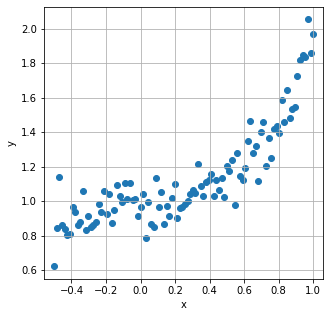

In [3]:
dataset = pd.read_csv('/content/dataEx5.csv')

x = dataset['x'].to_numpy()
x = np.reshape(x,(len(x),1))

y = dataset['y'].to_numpy()
y = np.reshape(y,(len(y),1))


fig = plt.figure(figsize=(5,5))
plt.scatter(x,y)
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.grid('on')
plt.show()

Podem veure que les dades no son lineals, sinó que més bé s'assemblen a una paràbola o exponencial així per aproximar-les farem servir una regressió de grau 2.

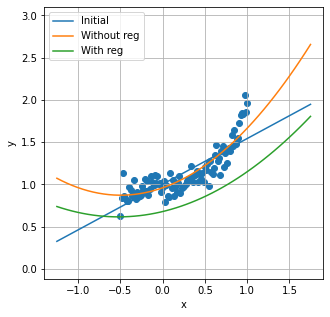

iteracions de cada model


(508, 515)

In [20]:
#INICIALITZEM ELS PARÀMETRES
w = np.array([[0,0,0]]).T
maxIts = 5000
tol = 0.0001
degree = 2
alpha = 0.01
X = constructDesignMatrix1D(x,degree)
X_mat = constructDesignMatrix1D(x,1)

#GRAU 1
w_cf = np.dot(np.linalg.inv(np.dot(X_mat.T, X_mat)), np.dot(X_mat.T, y))

#GRAU 2

#NO REGULARITZACIÓ
reg = 0
w_Vec, error_vec,iteracions = gradientDescent_RidgeReg(X, y, w, alpha, reg, maxIts , tol)

#AMB REGULARITZACIÓ
reg = 0.5
w_Reg, error_vec,iteracions_reg = gradientDescent_RidgeReg(X, y, w, alpha, reg, maxIts, tol)

#PLOT DEL MODEL
fig = plt.figure(figsize=(5,5))
plt.scatter(x,y)
plotModel1D(w_cf,x)
plotModel1D(w_Vec[:,-1],x)
plotModel1D(w_Reg[:,-1],x)
plt.axis('equal')
plt.grid('on')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['Initial','Without reg', 'With reg'])
plt.show()

print('iteracions de cada model')
iteracions,iteracions_reg

Fent servir aquets gràfic podem veure que en aquest dataset no hi ha molts outliers que ens puguin comprometre el model i al ser de grau 2 és bastant simple. Si féssim servir un model de graus més alts aleshores si que es podria produir overfitting, perè en aquest cas no així que no cal fer servir regularització.

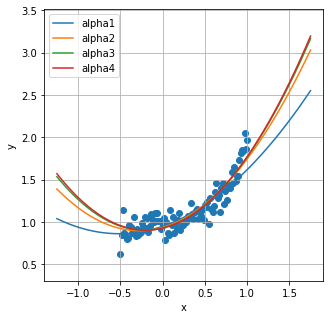

iteracions de cada model


(3240, 416, 156, 94)

In [21]:
#INICIALITZEM ELS PARÀMETRES
tol = 0.0001
alpha1 = 0.001
alpha2 = 0.1
alpha3 = 0.5
alpha4 = 1

X = constructDesignMatrix1D(x,degree)

#NO REGULARITZACIÓ
reg = 0
w_Vec1, error_vec1, iteracions1 = gradientDescent_RidgeReg(X, y, w, alpha1, reg, maxIts , tol)
w_Vec2, error_vec2, iteracions2 = gradientDescent_RidgeReg(X, y, w, alpha2, reg, maxIts , tol)
w_Vec3, error_vec3, iteracions3 = gradientDescent_RidgeReg(X, y, w, alpha3, reg, maxIts , tol)
w_Vec4, error_vec4, iteracions4 = gradientDescent_RidgeReg(X, y, w, alpha4, reg, maxIts , tol)


#PLOT DEL MODEL
fig = plt.figure(figsize=(5,5))
plt.scatter(x,y)
plotModel1D(w_Vec1[:,-1],x)
plotModel1D(w_Vec2[:,-1],x)
plotModel1D(w_Vec3[:,-1],x)
plotModel1D(w_Vec4[:,-1],x)
plt.axis('equal')
plt.grid('on')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['alpha1','alpha2','alpha3','alpha4'])
plt.show()

print('iteracions de cada model')
iteracions1,iteracions2,iteracions3,iteracions4


Podem veure que al augmentar les alphes (ritem d'entrenament) arriba al mateix lloc en menys iteracions, però això no sempre és bo ja que si creix massa pot tardar més o inclús no convergir mai. 
Per això veient el gràfic la alpha òptima sería entre alpha 1 i alpha 2, on agafi bé les dades però no faci overfitting. Aquesta és 0.01, coincidint amb la inicial.

La tolerància i les iteracions màximes ja estàn prou bé d'inicial i no cal tocar res.

Podem observar que el model òptim es el primer de tots sense regularitzar.